In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import scipy.signal as signal
import seaborn as sns
import pynapple as nap
import pickle
import scipy.stats as stats
from scipy.signal import find_peaks, peak_prominences
from BaselineRemoval import BaselineRemoval
import os

In [3]:
#UTILITIES
def single_spine_peak_plotting(input_f, input_fneu):
    corrected = input_f - (0.7*input_fneu)
        # a standard subtraction of fluorescence background immediately surrounding each ROI
    corrected_sample_trace = BaselineRemoval(corrected)
    corrected_trace = corrected_sample_trace.ZhangFit(repitition = 1000, lambda_ = 500)
        # an adaptively weighted iterated modified polynomial fit that ignores peaks and corrects baseline to 0
    mini_peaks, _ = find_peaks(corrected, height = 2*(abs(np.median(corrected_trace)) + abs(corrected_trace.min())), distance = 40)
        # scipy find_peaks function
        #then plot the traces you generate
    plt.plot(corrected)
    plt.plot(mini_peaks, corrected[mini_peaks], "x")
    plt.plot(np.full_like(corrected, threshold), "--",color = "grey")
    plt.plot(np.full_like(corrected, np.median(corrected)), "--", color = 'r')
    plt.show()
    
""" https://suite2p.readthedocs.io/en/latest/outputs.html explains the code to load a video's F / Fneu files (and others)
    With the F / Fneu files; we can iterate this function to see the outputs using the following:
    for f, fneu in zip(F, Fneu):
        single_spine_peak_plotting(f, fneu)"""


def single_synapse_baseline_correction_and_peak_return(input_f, input_fneu, return_peaks = True):
    
    corrected_trace = input_f - (0.7*input_fneu)
    corrected_trace = BaselineRemoval(corrected_trace)
    corrected_trace = corrected_trace.ZhangFit(repitition = 100)
    peaks, _ = find_peaks(corrected_trace, height = 2*(abs(np.median(corrected_trace)) + abs(corrected_trace.min())), distance = 40)
    amplitudes = corrected_trace[peaks] - np.median(corrected_trace)
    
    if return_peaks == True:
        return peaks
    else:
        return amplitudes

""" please go from this file to the suite2p_utility notebook to see how this will be used within Suite2p's output """ 

def fluorescence_decay():
    """Here we need to determine the number of frames after a peak"""    
    
    
 #The following are  lines of code written by Marti, who I generally trust to write cohesive and concise code
# for coding; If you find my functions above to be inadequate you may impliment these instead
    
    

def detect_spikes_by_mod_z(input_trace, **signal_kwargs):
    median = np.median(input_trace)
    deviation_from_med = np.array(input_trace) - median
    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(1.4826*mad)
    return signal.find_peaks(mod_zscore, **signal_kwargs)[0]


def plot_spikes(raw_trace, detector_func, detector_trace=None, **detector_kwargs):
    if detector_trace is None:
        detector_input_trace = raw_trace.copy()
    else:
        detector_input_trace = detector_trace.copy()
    spikes = detector_func(detector_input_trace, **detector_kwargs)
    plt.plot(range(len(raw_trace)), raw_trace, color="blue")
    for spk in spikes:
        plt.axvline(spk, color="red")
    plt.show()
    
    
    
    
# rolling_min / remove_bleaching are basic polynomial-based baseline corrections; this will not remove noise either
# these can be compared to the more complicated ZhangFit iteratively-weighted approach (airPLS method)

def rolling_min(input_series, window_size):
    r = input_series.rolling(window_size, min_periods=1)
    m = r.min()
    return m


def remove_bleaching(input_trace):
    min_trace = rolling_min(pd.Series(input_trace), window_size=int(len(input_trace)/10))
    fit_coefficients = np.polyfit(range(len(min_trace)), min_trace, 2)
    fit = np.poly1d(fit_coefficients)
    return input_trace - fit(range(len(input_trace)))

SUITE2P_STRUCTURE = {
    "F": ["suite2p", "plane0", "F.npy"],
    "Fneu": ["suite2p", "plane0", "Fneu.npy"],
    #'spks': ["suite2p", "plane0", "spks.npy"],
    "stat": ["suite2p", "plane0", "stat.npy"],
    "iscell": ["suite2p", "plane0", "iscell.npy"],
}
""" spks is not really necessary with our current set up since the spont. events are all pretty uniform, and are below 
    AP threshold (and therefore will not need to be deconvolved into action potentials themselves)"""

def load_npy_array(npy_path):
    return np.load(npy_path, allow_pickle=True) #functionally equivalent to np.load(npy_array) but iterable; w/ Pickle


def load_npy_df(npy_path):
    return pd.DataFrame(np.load(npy_path, allow_pickle=True)) #load suite2p outputs as pandas dataframe


def load_npy_dict(npy_path):
    return np.load(npy_path, allow_pickle=True)[()] #load .npy as dictionary

"""
The following 3 func. are used to translate_suite2p_outputs_to_csv;
check_for_suite2p_output is defined below: primarily for if iscell is not included (it always is)

Then, we append the folder location of suite2p outputs into the current path (found_output_paths = files in os.walk(path))
found_output_paths.append(current_path)
"""

def check_for_suite2p_output(path, check_for_iscell=False):
    for file, path_to_file in SUITE2P_STRUCTURE.items():
        if file == "iscell" and not check_for_iscell:
            continue
        if not os.path.isfile(os.path.join(path, *path_to_file)):
            return False
    return True
    #Strictly to check for iscell.npy; I originally forgot to include this when Marti Ritter wrote the code
    # I am also too scared to change this before my Master's less this break the pipeline
    # For the synapses it also is not relatively important since we assume all detected ROIs are real* synapses


def get_all_suite2p_outputs_in_path(path, check_for_iscell=False):
    found_output_paths = []
    
    for current_path, directories, files in os.walk(path):
        if check_for_suite2p_output(current_path, check_for_iscell=check_for_iscell):
            found_output_paths.append(current_path)
    return found_output_paths




def load_suite2p_output(path, use_iscell=False):
    """here we define our suite2p dictionary from the SUITE2P_STRUCTURE...see above"""
    suite2p_dict = {
        "F": load_npy_array(os.path.join(path, *SUITE2P_STRUCTURE["F"])),
        "Fneu": load_npy_array(os.path.join(path, *SUITE2P_STRUCTURE["Fneu"])),
        "stat": load_npy_df(os.path.join(path, *SUITE2P_STRUCTURE["stat"]))[0].apply(pd.Series),
    }

    if use_iscell == False:
        suite2p_dict["IsUsed"] = [(suite2p_dict["stat"]["skew"] >= 0) & 
                                                (suite2p_dict['stat']['footprint'] < 3.0) &
                                                (suite2p_dict['stat']['footprint'] > 0.0)]

        suite2p_dict["IsUsed"] = pd.DataFrame(suite2p_dict["IsUsed"]).iloc[:,0:].values.T
        suite2p_dict["IsUsed"] = np.squeeze(suite2p_dict["IsUsed"])
    else:
        suite2p_dict["IsUsed"] = load_npy_df(os.path.join(path, *SUITE2P_STRUCTURE["iscell"]))[0].astype(bool)

    return suite2p_dict
"""
Possible to append this function further for synapse exclusion
 for example, append the document based on 
suite2p_dict["stat"] using values for ["skew"]/["npix"]/["compactness"]
"""


def translate_suite2p_dict_to_df(suite2p_dict):
    """this is the principle function in which we will create our .csv file structure; and where we will actually use
        our detector functions for spike detection and amplitude extraction"""
    spike_amplitudes = [single_synapse_baseline_correction_and_peak_return(f_trace, fneu_trace, return_peaks = False) 
                       for (f_trace, fneu_trace) in zip(suite2p_dict["F"], suite2p_dict["Fneu"])]
    
    spikes_per_neuron = [single_synapse_baseline_correction_and_peak_return(f_trace, fneu_trace) 
                             for (f_trace, fneu_trace) in zip(suite2p_dict["F"], suite2p_dict["Fneu"])]
#spikes_per_neuron from single_cell_peak_return OUTPUT = list of np.arrays        
    df = pd.DataFrame({"IsUsed": suite2p_dict["IsUsed"],
                       "Skew": suite2p_dict["stat"]["skew"],
                       "PeakTimes": spikes_per_neuron,
                       "Amplitudes": spike_amplitudes,
                       "Total Frames": len(suite2p_dict["F"].T)})
                       
    df.index.set_names("SynapseID", inplace=True)
    return df

def translate_suite2p_outputs_to_csv(input_path, output_path, overwrite=False, check_for_iscell=False):
    """This will create .csv files for each video loaded from out data fram function below.
        The structure will consist of columns that list: "Amplitudes": spike_amplitudes})
        
        col1: ROI #, col2: IsUsed (from iscell.npy); boolean, col3: Skew (from stats.npy); could be replaced with any 
        stat >> compactness, col3: spike frames (relative to input frames), col4: amplitude of each spike detected measured 
        from the baseline (the median of each trace)"""
    
    suite2p_outputs = get_all_suite2p_outputs_in_path(input_path)
    
    for suite2p_output in suite2p_outputs:
        output_directory = os.path.basename(suite2p_output)
        translated_path = os.path.join(output_path, f"{output_directory}.csv")
        if os.path.exists(translated_path) and not overwrite:
            print(f"CSV file {translated_path} already exists!")
            continue

        suite2p_dict = load_suite2p_output(suite2p_output)
        suite2p_df = translate_suite2p_dict_to_df(suite2p_dict)

        suite2p_df.to_csv(translated_path)

        
#For establishing ImageJ/CellProfiler baseline
"""
def load_imageJ_xl_sheet(imageJ_xl_output_path, xl_sheetname, return_array=True):
    imageJ_xl = pd.read_excel(imageJ_xl_output_path, engine='openpyxl',
                       sheet_name = xl_sheetname, header = None)
    processed_imageJ_xl = imageJ_xl.T
        #transposed to match the output of suite2p / make more legible for humans
    processed_imageJ_xl_header = processed_imageJ_xl.iloc[0]
    processed_imageJ_xl = processed_imageJ_xl[1:]
    processed_imageJ_xl.columns = processed_imageJ_xl_header
    processed_imageJ_xl_numpy_array = pd.DataFrame.to_numpy(processed_imageJ_xl)
    if return_array == True:
        return processed_imageJ_xl_numpy_array
    else:
        return processed_imageJ_xl

        %%writefile syn_analysis_utility.py
"""

frame_rate = 20
EXPERIMENT_DURATION = 240
#total number of seconds that the experiment lasts (tends to be flexible so we will have to figure out how to set this)
FRAME_INTERVAL = 20
#frame_interval is calculated as 1 / frame_rate
#we are not doing binned experiments so this is not necessary; again, will comment out later, but for now too scared of bugs
BIN_WIDTH = 10
#FILTER_NEURONS applies strictly to 'iscell.npy' file; in most instances, we will use all ROIs anyway, but keep true for clarity
FILTER_NEURONS = True



def list_all_files_of_type(input_path, filetype):
    return [file for file in os.listdir(input_path) if file.endswith(filetype)]

def string_to_list_translator(input_string, strip_before_split="[ ]", split_on=" "):
    split_string = input_string.strip(strip_before_split).split(split_on)
    return list(filter(None, split_string))

def spike_list_translator(input_string):
    """This funciton is nested in the next. It is designed to convert the time stamp of each event into a time
        during the experiment (e.g. frame 2 = 1.1 seconds into the recording)"""
    string_list = string_to_list_translator(input_string)
    return np.array(string_list).astype(int) * 0.05

def amplitude_list_translator(input_string):
    amp_string_list = string_to_list_translator(input_string)
    amp_string_list = np.array(amp_string_list).astype(float)
    return np.around(amp_string_list)

def spike_df_iterator(input_path, return_name=True):
    for csv_file in list_all_files_of_type(input_path, "csv"):
        csv_path = os.path.join(input_path, csv_file)
        csv_df = pd.read_csv(csv_path, converters={"PeakTimes":spike_list_translator , "Amplitudes":amplitude_list_translator})
        yield csv_df, csv_file if return_name else csv_df

        
   #Again, binned stats are not necessary for synapses, but regardless, we can leave this here for now
def calculate_binned_stats(input_df):
    local_df = input_df.copy()

    bins = np.arange(0, EXPERIMENT_DURATION + BIN_WIDTH, BIN_WIDTH)
    population_spikes, _ = np.histogram(np.hstack(local_df["PeakTimes"].values), bins=bins)
    population_frequency = population_spikes / BIN_WIDTH

    bin_stats = pd.DataFrame.from_dict({
        "Bin_Limits": [(bins[bin_index], bins[bin_index + 1]) for bin_index in range(len(bins) - 1)],
        "Spikes": population_spikes,
        "Frequency": population_frequency})
        
    return bin_stats


def calculate_cell_freq(input_df):
    output_df = input_df.copy()
    output_df["SpikesCount"] = output_df["PeakTimes"].str.len()
    output_df["SpikesFreq"] = output_df["SpikesCount"] / (input_df["Total Frames"] * frame_rate) #divide by total # of frames NOT framerate
    return output_df

def calculate_cell_isi(input_df): #isi == interspike interval
    output_df = input_df.copy()
    output_df["SpikesDiff"] = output_df["PeakTimes"].apply(lambda x: list(pd.Series(x).diff().dropna()))
    output_df["DiffAvg"] = output_df["SpikesDiff"].apply(lambda x: pd.Series(x).mean())
    output_df["DiffMedian"] = output_df["SpikesDiff"].apply(lambda x: pd.Series(x).median())
    output_df["DiffCV"] = output_df["SpikesDiff"].apply(lambda x: pd.Series(x).std()) / output_df["DiffAvg"] * 100
    return output_df

#below I will need to accurately figure out how to integrate this in, I should meet with Marti Ritter next week to do so

def calculate_spike_amplitudes(input_df):
    output_df = input_df.copy()
    output_df["AvgAmplitude"] = output_df["Amplitudes"].apply(lambda x: pd.Series(x).mean())
    output_df["SpkAmpMedian"] = output_df["Amplitudes"].apply(lambda x: pd.Series(x).median())
    output_df["SpkAmpCV"] = output_df["Amplitudes"].apply(lambda x: pd.Series(x).std()) / output_df["AvgAmplitude"] * 100
    return output_df


def calculate_cell_stats(input_df, calculate_freq=True, calculate_isi=True, calculate_amplitudes=True):
    output_df = input_df.copy()
    if calculate_freq:
        output_df = calculate_cell_freq(output_df)
    if calculate_isi:
        output_df = calculate_cell_isi(output_df)
    if calculate_spike_amplitudes:
        output_df = calculate_spike_amplitudes(output_df)
    return output_df



def process_spike_csvs_to_pkl(input_path, output_path, overwrite=False):
    """This will convert .csv files into pickle files which behave like dataframes; but are faster and preserve CPU RAM"""
    for spike_df, file_name in spike_df_iterator(input_path):
        processed_path = os.path.join(output_path, 
                                      f"{os.path.splitext(file_name)[0]}"
                                      f"Dur{int(EXPERIMENT_DURATION)}s"
                                      f"Int{int(FRAME_INTERVAL*1000)}ms"
                                      f"Bin{int(BIN_WIDTH*1000)}ms"
                                        + ("_filtered" if FILTER_NEURONS else "") +
                                      ".pkl")

        if os.path.exists(processed_path) and not overwrite:
            print(f"Processed file {processed_path} already exists!")
            continue
            
        if FILTER_NEURONS:
            spike_df = spike_df[spike_df["IsUsed"]]
            
        processed_dict = {
            "cell_stats": calculate_cell_stats(spike_df),
            "binned_stats": calculate_binned_stats(spike_df)}
        

        pd.to_pickle(processed_dict, processed_path)


In [13]:
def get_all_suite2p_outputs_in_path(path, check_for_iscell=False):
    found_output_paths = []
    
    for current_path, directories, files in os.walk(path):
        if check_for_suite2p_output(current_path, check_for_iscell=check_for_iscell):
            found_output_paths.append(current_path)
    return found_output_paths

['C:\\Users\\jcbegs\\Desktop\\GCaMP_optimization\\pkl3']

In [52]:
def get_all_pkl_outputs_in_path(path):
    processed_files = []
    file_names = []

    for current_path, directories, files in os.walk(path):
        for file_name in files:
            full_path = os.path.join(current_path, file_name)
            processed_files.append(full_path)
        file_names.append(files)
    return processed_files, file_names[0]

files, names = get_all_pkl_outputs_in_path(r'C:\Users\jcbegs\Desktop\GCaMP_optimization\pkl3')
for j in names:
    print(j)

wtRt_225k_.0.5ul_hSyn_0.4ulmRuby_DIV19_100_trigger25ms_r001Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV19_baseline_25ms_40%exp_r001Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV19_constant_LED_50ms_30%exp_r004Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV19_triggered_25ms_100%exp_r003Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV19_triggered_25ms_40%exp_r002Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_DNQX_r002Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_DNQX_r003Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_DNQX_r004Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_NBQX_r002Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_NBQX_r003Dur240sInt20000msBin10000ms_filtered.pkl
wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_NBQX_r004Dur240sInt20000msBin10000ms_fi

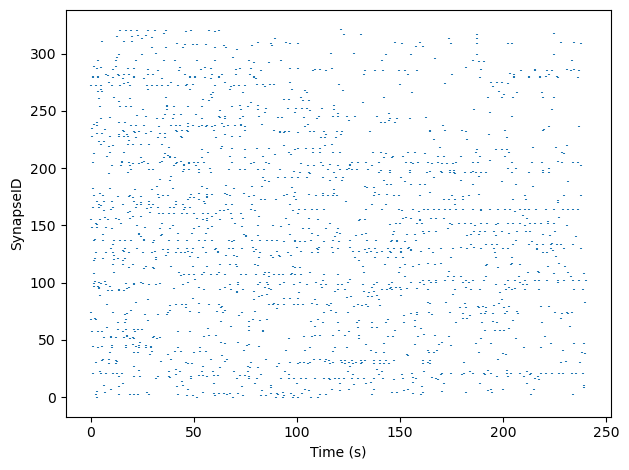

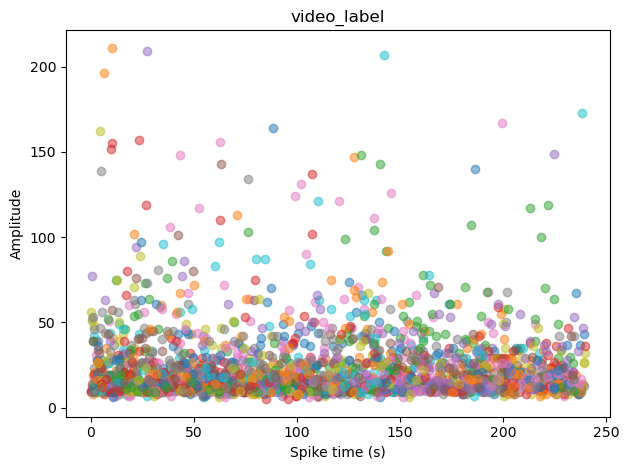

wtRt_225k_.0.5ul_hSyn_0.4ulmRuby_DIV19_100_trigger25ms_r001Dur240sInt20000msBin10000ms_filtered.pkl


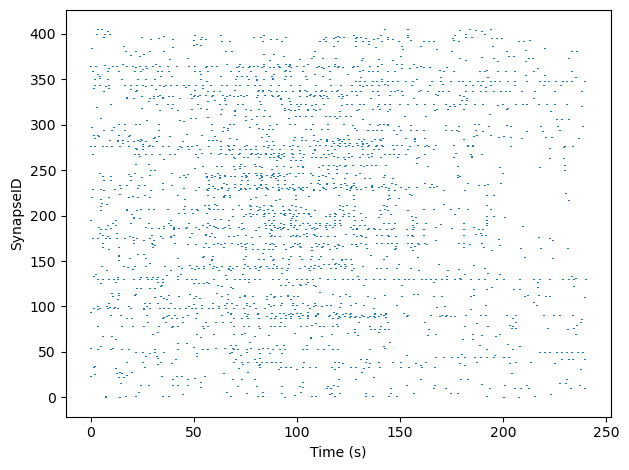

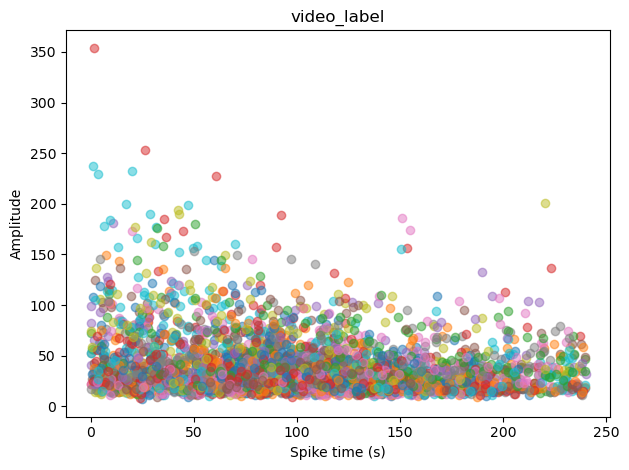

wtRt_225k_.0.5ul_hSyn_DIV19_baseline_25ms_40%exp_r001Dur240sInt20000msBin10000ms_filtered.pkl


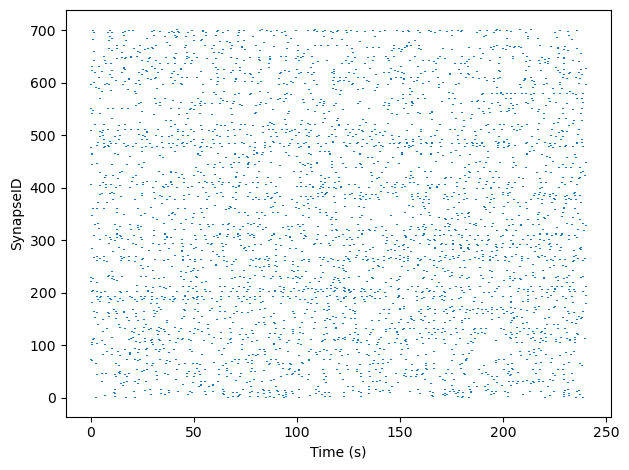

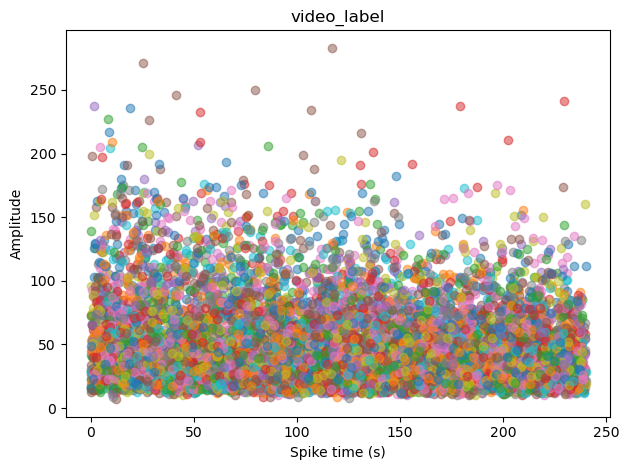

wtRt_225k_.0.5ul_hSyn_DIV19_constant_LED_50ms_30%exp_r004Dur240sInt20000msBin10000ms_filtered.pkl


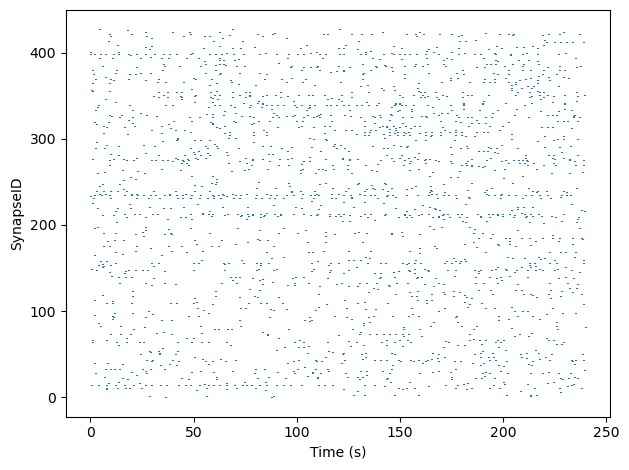

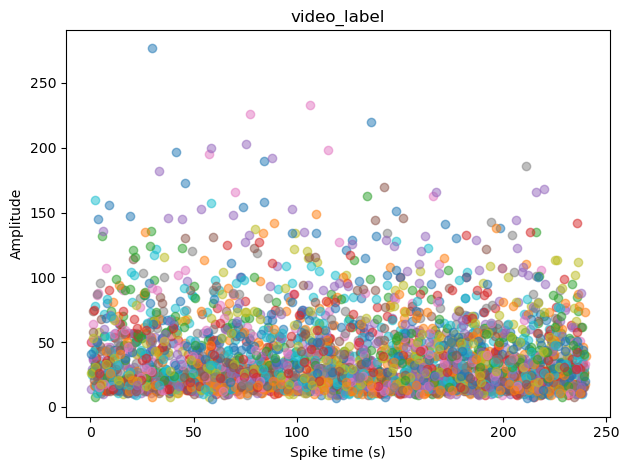

wtRt_225k_.0.5ul_hSyn_DIV19_triggered_25ms_100%exp_r003Dur240sInt20000msBin10000ms_filtered.pkl


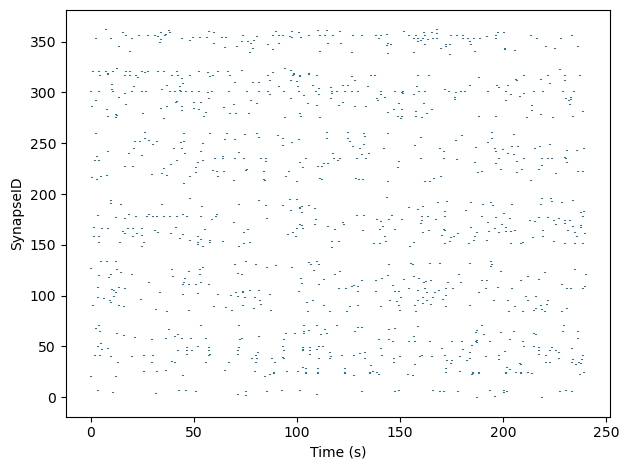

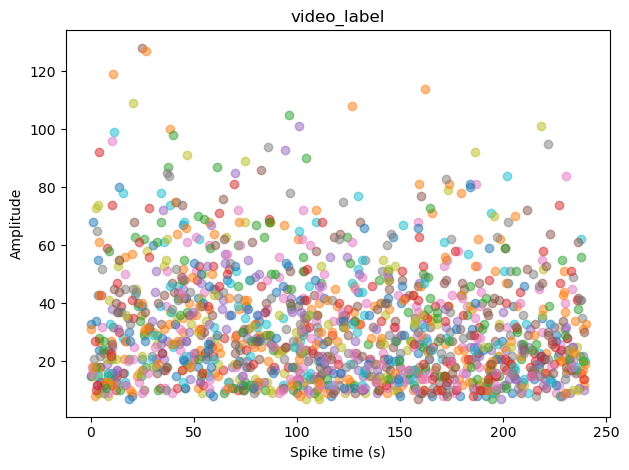

wtRt_225k_.0.5ul_hSyn_DIV19_triggered_25ms_40%exp_r002Dur240sInt20000msBin10000ms_filtered.pkl


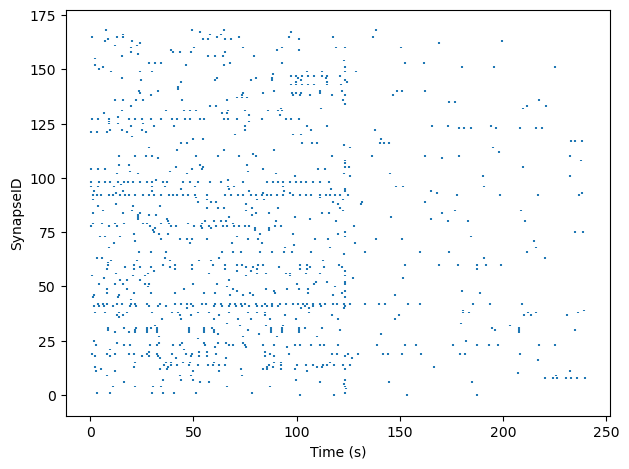

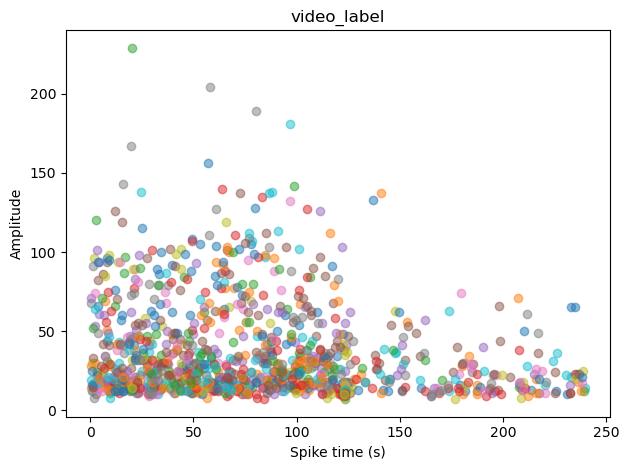

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_DNQX_r002Dur240sInt20000msBin10000ms_filtered.pkl


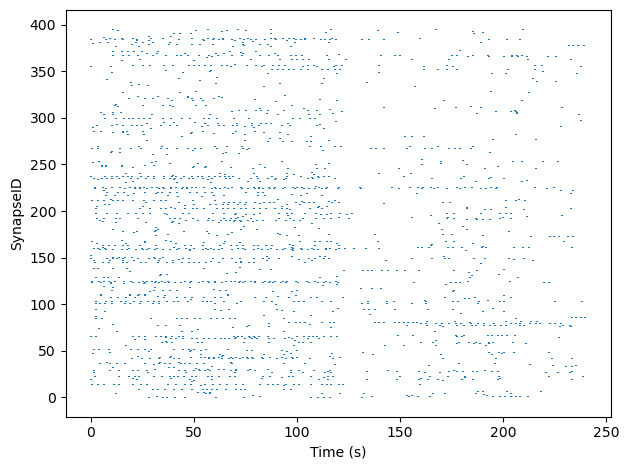

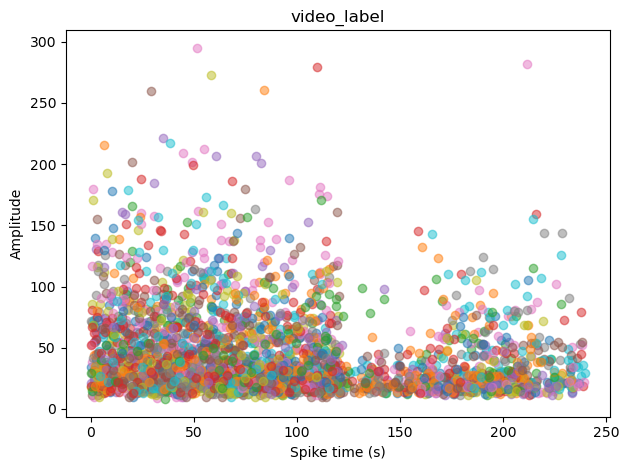

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_DNQX_r003Dur240sInt20000msBin10000ms_filtered.pkl


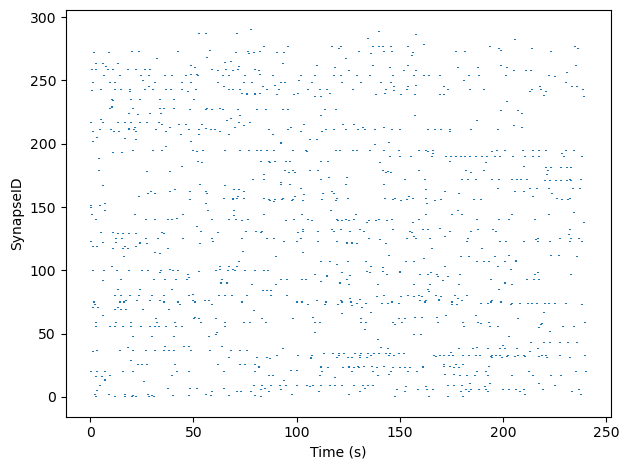

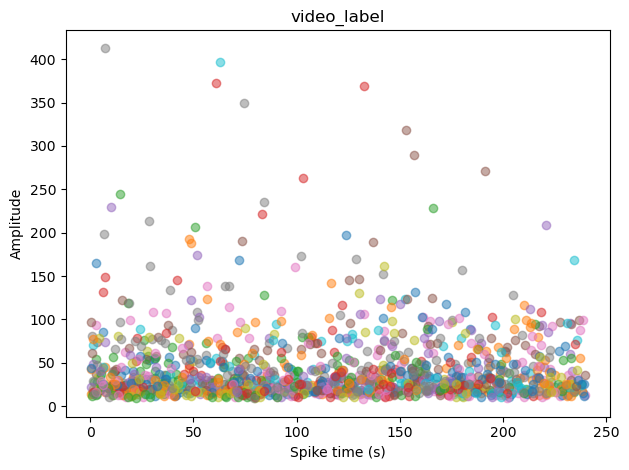

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_DNQX_r004Dur240sInt20000msBin10000ms_filtered.pkl


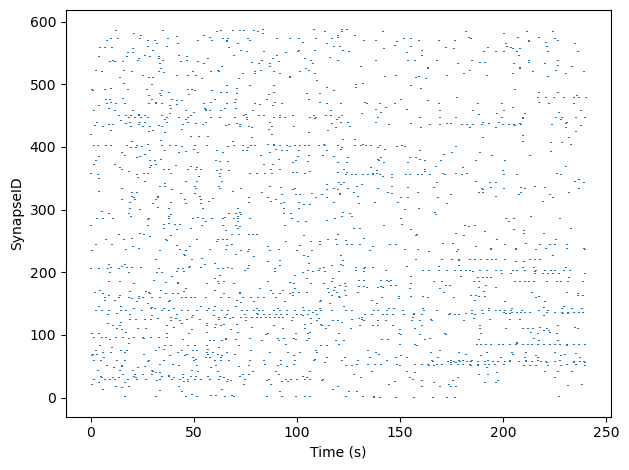

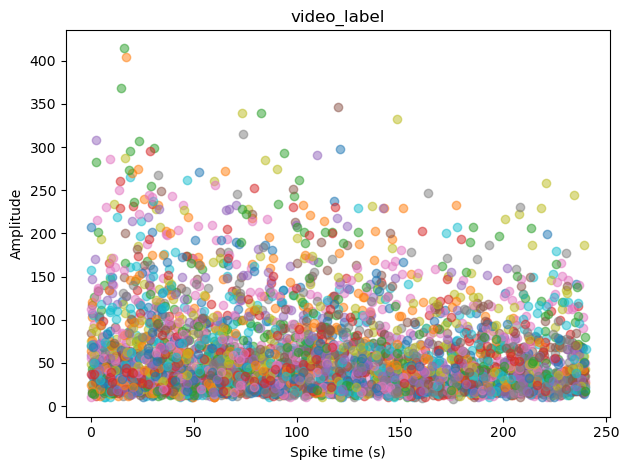

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_NBQX_r002Dur240sInt20000msBin10000ms_filtered.pkl


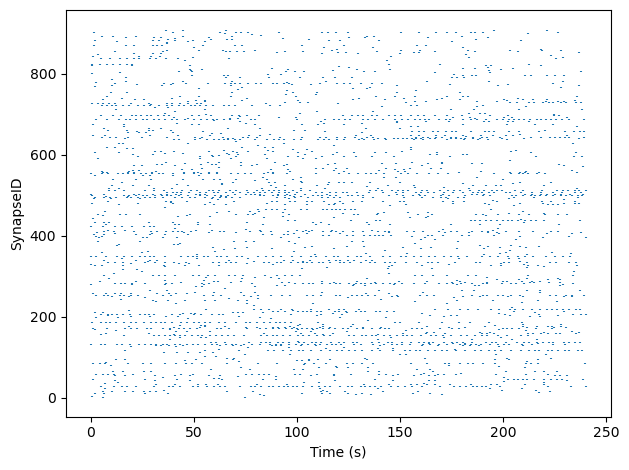

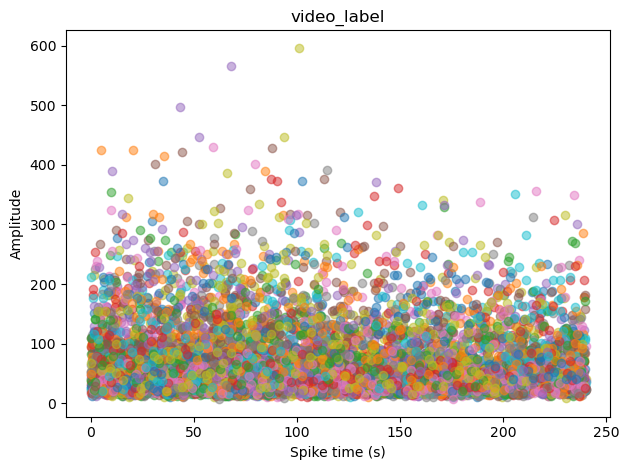

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_NBQX_r003Dur240sInt20000msBin10000ms_filtered.pkl


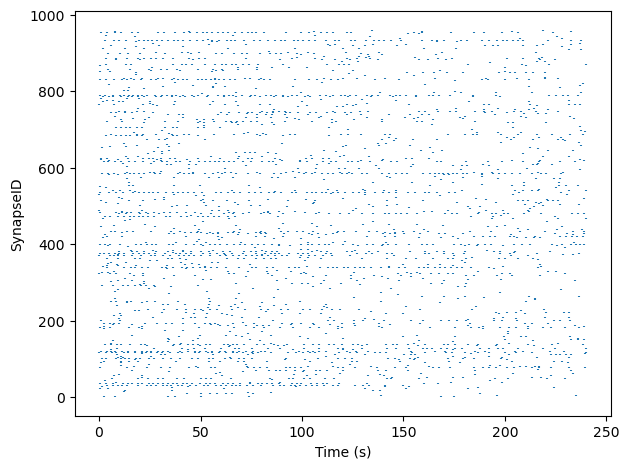

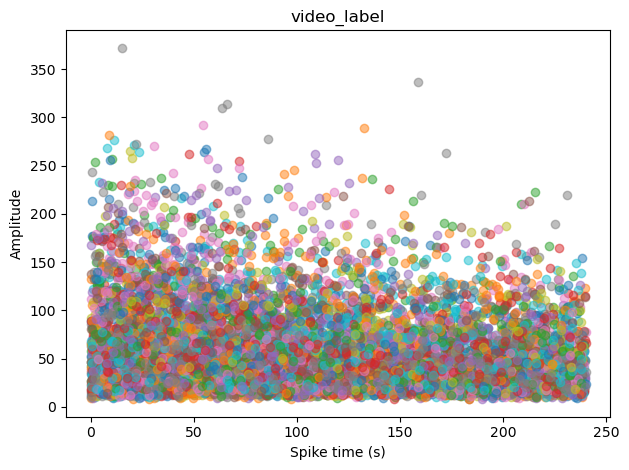

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_NBQX_r004Dur240sInt20000msBin10000ms_filtered.pkl


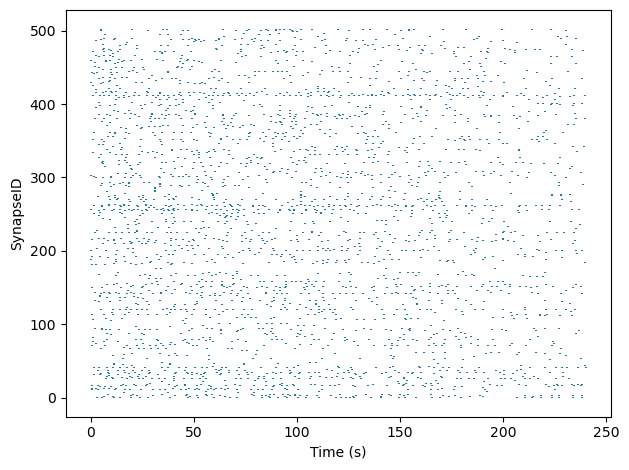

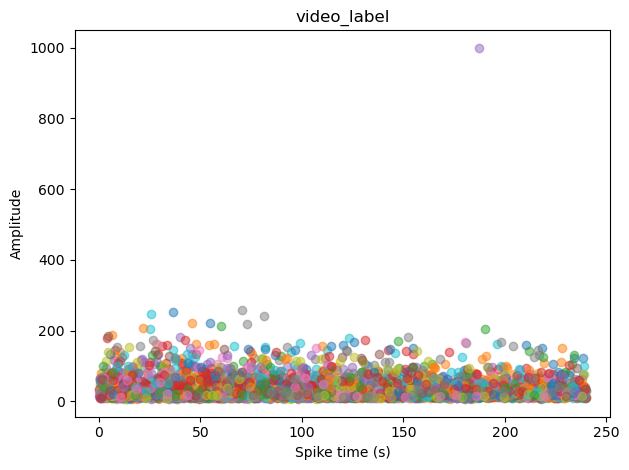

wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_r001_cs1Dur240sInt20000msBin10000ms_filtered.pkl


In [55]:
n = 0
for i in files:
    pynapple_plots(i)
    print(names[n])
    n+=1


In [46]:
#new way to automatically generate rasterplot and amplitude measurement for each video (will be nice for final figure production like Hatem did)
def get_all_pkl_outputs_in_path(path):
    processed_files = []

    for current_path, directories, files in os.walk(path):
        for file_name in files:
            full_path = os.path.join(current_path, file_name)
            processed_files.append(full_path)
    return processed_files


def pynapple_plots(file_path):#, video_label):
    import warnings
    warnings.filterwarnings('ignore')
    
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    df_cell_stats = data['cell_stats']
    df_cell_stats
# i=0 #to plot w/o spaces
    for i, idx in enumerate(df_cell_stats['SynapseID']):
#     print(idx)
        plt.eventplot(df_cell_stats[df_cell_stats['SynapseID']==idx]['PeakTimes'],lineoffsets=i,linelength=0.8)
#     i+=1
    plt.ylabel('SynapseID')
    plt.xlabel('Time (s)')
    plt.tight_layout()

    my_tsd = {}
    for idx in df_cell_stats['SynapseID'][0:]:
        my_tsd[idx] = nap.Tsd(t=df_cell_stats[df_cell_stats['SynapseID']==idx]['PeakTimes'][idx],
                            d=df_cell_stats[df_cell_stats['SynapseID']==idx]['Amplitudes'][idx],time_units='s')
        
    Interval_1 = nap.IntervalSet(0,240)

    Interval_2 = nap.IntervalSet(250,290)
    Interval_3 = nap.IntervalSet(290,450)
    
    interval_set = [Interval_1]#,
                #Interval_2]
    plt.figure()
    for i in range(1): #change range for multiple intervals
        plt.title('video_label')
        # plt.title(f'interval {i+1}')
        for idx in my_tsd.keys():
            plt.plot(my_tsd[idx].restrict(interval_set[i]).index,my_tsd[idx].restrict(interval_set[i]).values,color=f'C{idx}',marker='o',ls='',alpha=0.5)
        plt.ylabel('Amplitude')
        plt.xlabel('Spike time (s)')
        plt.tight_layout()
        plt.show()

            ## You can then just group the amplitude as you want for later analysis

    transient_count = []
    for idx in my_tsd.keys():
        transient_count.append(my_tsd[idx].restrict(interval_set[0]).shape[0])


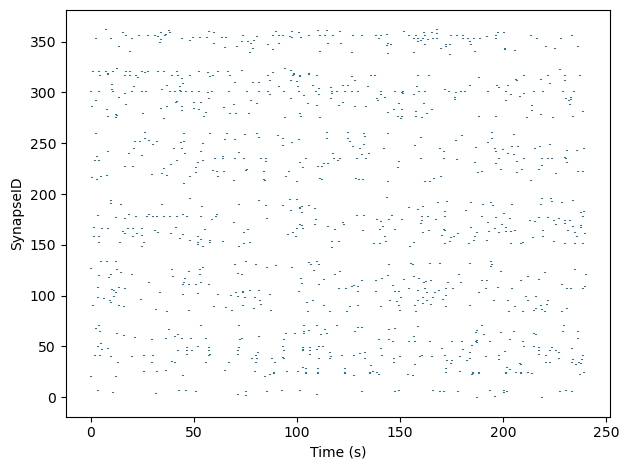

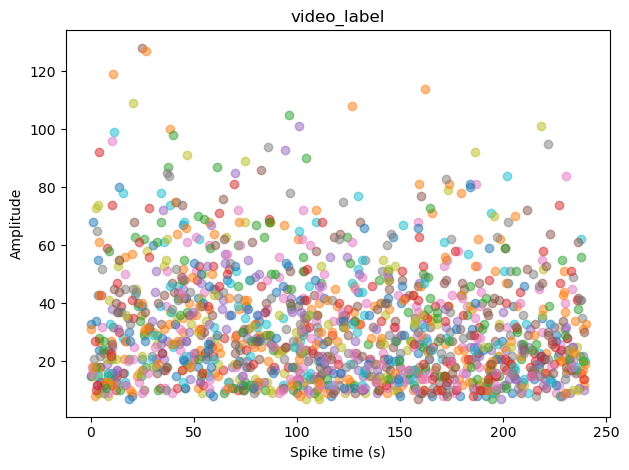

In [57]:
pynapple_plots(r'E:\230725_hSzn_GCaMP6_DIV19_exp_tests_2_decay\step3\wtRt_225k_.0.5ul_hSyn_DIV19_triggered_25ms_40%exp_r002Dur180sInt20000msBin10000ms_filtered.pkl')

In [58]:
pynapple_plots(r'C:\Users\jcbegs\Desktop\GCaMP_optimization\pkl3\wtRt_225k_.0.5ul_hSyn_DIV19_triggered_25ms_40%exp_r002Dur180sInt20000msBin10000ms_filtered.pkl', '25ms triggering w max LED')

TypeError: pynapple_plots() takes 1 positional argument but 2 were given

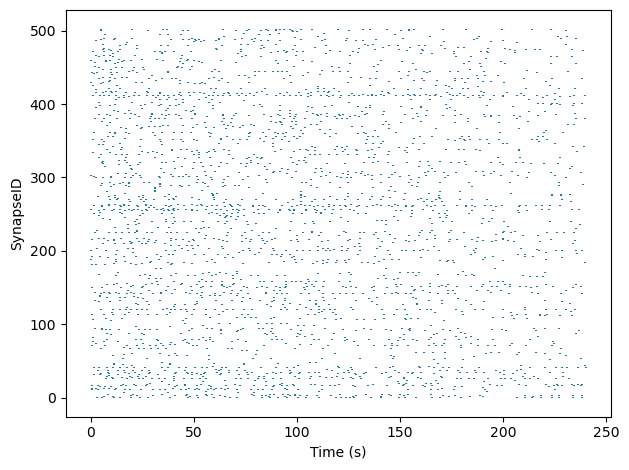

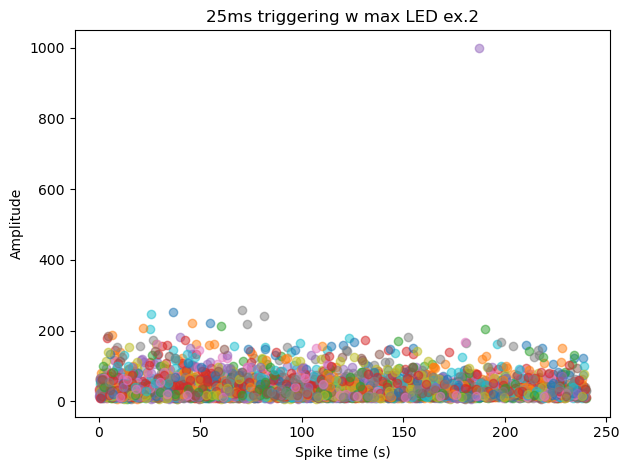

In [10]:
pynapple_plots(r'C:\Users\jcbegs\Desktop\GCaMP_optimization\pkl3\wtRt_225k_.0.5ul_hSyn_DIV21_100%_25ms_r001_cs1Dur240sInt20000msBin10000ms_filtered.pkl', '25ms triggering w max LED ex.2')

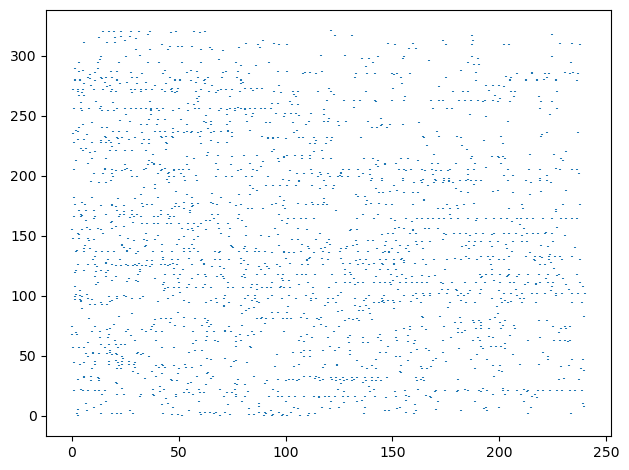

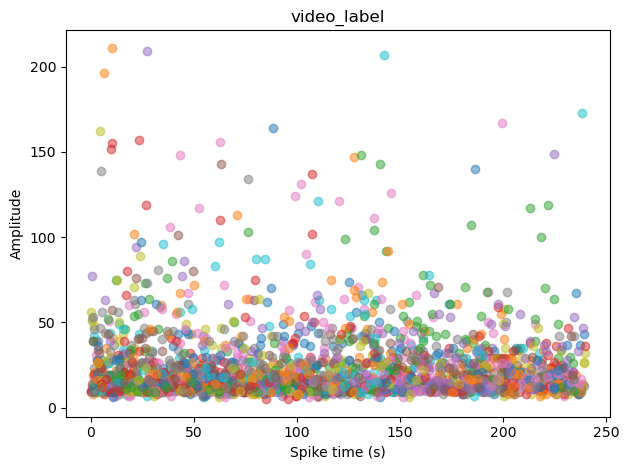

In [4]:
#rastermap

with open(r'C:\Users\jcbegs\Desktop\GCaMP_optimization\pkl3\wtRt_225k_.0.5ul_hSyn_0.4ulmRuby_DIV19_100_trigger25ms_r001Dur240sInt20000msBin10000ms_filtered.pkl', 'rb') as f:
    data = pickle.load(f)
df_cell_stats = data['cell_stats']
df_cell_stats
# i=0 #to plot w/o spaces
for i, idx in enumerate(df_cell_stats['SynapseID']):
#     print(idx)
    plt.eventplot(df_cell_stats[df_cell_stats['SynapseID']==idx]['PeakTimes'],lineoffsets=i,linelength=0.8)
#     i+=1
plt.tight_layout()



#PyNapple Amplitudes 
## here I generate a dictionary that contains nap.Tsd (timeseries data) objects, which is easy to handle when you want to do
## so you can later all each neurons with their ids

my_tsd = {}
for idx in df_cell_stats['SynapseID'][0:]:
    my_tsd[idx] = nap.Tsd(t=df_cell_stats[df_cell_stats['SynapseID']==idx]['PeakTimes'][idx],
                          d=df_cell_stats[df_cell_stats['SynapseID']==idx]['Amplitudes'][idx],time_units='s')

    
## Define the intervals you want to extract, here the unit is in second, so might be different from frames.
## You can later use the .restrict(intervals) function on the nap.Tsd object to only extract the events 
## happening in this period of time.

Interval_1 = nap.IntervalSet(0,240)

Interval_2 = nap.IntervalSet(250,290)
Interval_3 = nap.IntervalSet(290,450)
    
interval_set = [Interval_1]#,
                #Interval_2]


## you can change this to any other interval values
## There will be error messages when there is not spikes in the list after the restriction, 
## but you can just ignore that. Here I shut that down in this cell.

import warnings
warnings.filterwarnings('ignore')
## just to get rid of the warnings


## plot spike time vs amplitude in each intervals
plt.figure()
for i in range(1): #change range for multiple intervals
    plt.title('video_label')
    # plt.title(f'interval {i+1}')
    for idx in my_tsd.keys():
        plt.plot(my_tsd[idx].restrict(interval_set[i]).index,my_tsd[idx].restrict(interval_set[i]).values,color=f'C{idx}',marker='o',ls='',alpha=0.5)
    plt.ylabel('Amplitude')
    plt.xlabel('Spike time (s)')
    plt.tight_layout()
    plt.show()

## You can then just group the amplitude as you want for later analysis

transient_count = []
for idx in my_tsd.keys():
    transient_count.append(my_tsd[idx].restrict(interval_set[0]).shape[0])

In [ ]:
"""
desired_key = "lam"
low_std = []
for element in stat:
    if desired_key in element:
        low_std.append(element[desired_key])

np.mean(stat[601]['lam']) """ #addition for stat filtering of final ROIs for silent neurons vs noise for Harald

#renaming files before processing for Harald AB's
import os

# Specify the file path
file_path = '/path/to/file.txt'

# Extract the directory and filename from the file path
directory = os.path.dirname(file_path)
filename = os.path.basename(file_path)

# Add the directory to the filename
new_filename = os.path.join(directory, f'{directory}_{filename}')

# Rename the file
os.rename(file_path, new_filename)